In [1]:
import torch
from torchvision.models import alexnet
from torchsummary import summary
from utils import classify
import numpy as np
from matplotlib import pyplot as plt
import os
from male import get_important_neurons, get_positions, associate_channels

/home/adamwsl/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
%load_ext autoreload

In [3]:
filename = 'lakeside.jpg'

In [4]:
model = alexnet(pretrained=True)
_ = model.eval()
# summary(model, (3, 224, 224))

In [5]:
%autoreload 2
probabilities, top_probabilities, categories, input_batch, input_tensor = classify(filename, model)

In [6]:
image_center_resized = input_tensor.numpy()
image_center_resized = np.transpose(image_center_resized, (1, 2, 0))
if not os.path.exists(os.path.join('images', 'clipped', filename)):
    plt.imsave(os.path.join('images', 'clipped', filename), image_center_resized)

In [7]:
import pandas as pd
import os
descriptions = pd.read_csv(os.path.join('milan_results', 'alexnet_imagenet.csv'))
#layer_names = ['conv1'] + ['layer' + str(i) for i in range(1, 5, 1)]
layer_names = ['conv5']
layer_map = {'conv1' : model.features[0], 
             'conv2' : model.features[3], 
             'conv3' : model.features[6], 
             'conv4' : model.features[8], 
             'conv5' : model.features[10]}

In [8]:
how_much_highest = 10

In [9]:
per_layer_results, per_layer_activations = get_important_neurons(how_much_highest, 
                                                                 input_batch, 
                                                                 model, 
                                                                 layer_names, 
                                                                 layer_map, 
                                                                 descriptions, 
                                                                 probabilities)

/home/adamwsl/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [18]:
per_layer_positions = get_positions(per_layer_results, per_layer_activations)

In [21]:
prompt = str(categories[0])

In [15]:
x = associate_channels(input_batch=input_batch, 
                       prev_layer=layer_map['conv4'], 
                       prev_out_channels=256,
                       curr_layer=layer_map['conv5'], 
                       target_ch_id=2, 
                       model=model)
print(tops := list(torch.argsort(x).numpy())[:10])

[71, 119, 253, 125, 201, 94, 226, 250, 0, 48]


In [16]:
query = descriptions[descriptions['layer'] == 'conv4']
tops = list(torch.argsort(x).numpy())[:5]
print(tops)
query =  query[query['unit'].isin(tops)]
query.set_index('unit', inplace=True)
query = query.loc[tops]
query.reset_index(inplace=True)
query

[71, 119, 253, 125, 201]


,unit,layer,description
0,71,conv4,Layered part of all objects
1,119,conv4,Text
2,253,conv4,Stripes
3,125,conv4,Dog heads
4,201,conv4,Flower petals and flowers


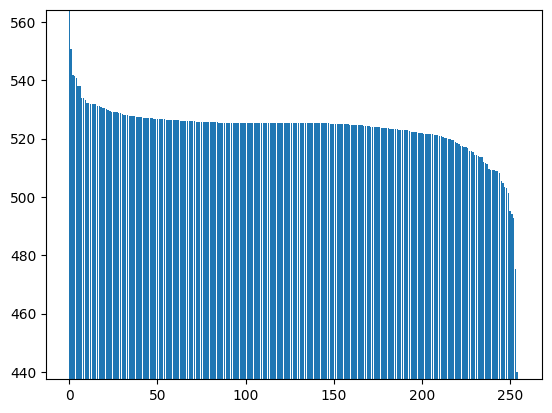

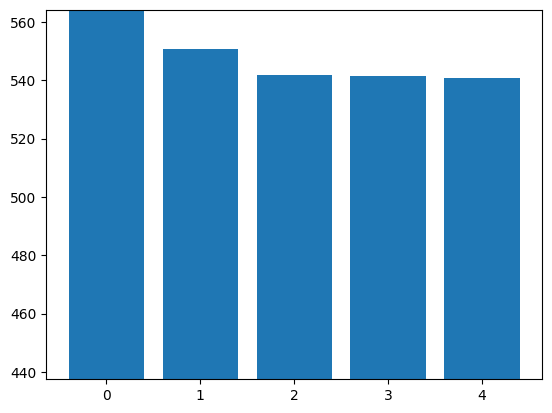

In [17]:
y = list(x)
y.sort(reverse=True)
plt.ylim(min(y), max(y))
plt.bar(range(len(y)), y)
plt.show()
plt.ylim(min(y), max(y))
plt.bar(range(len(y[:5])), y[:5])
plt.show()